# E-Commerce Demand Forecasting & Consumer Trend Segmentation

In [1]:
!pip -q install pandas numpy matplotlib seaborn scikit-learn tensorflow openpyxl pytrends pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis, probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from pytrends.request import TrendReq
import warnings
warnings.filterwarnings('ignore')

## Data Loading & Preprocessing

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)
df.dropna(inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

daily_sales = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()
all_days = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max())
daily_sales = daily_sales.reindex(all_days, fill_value=0)
daily_sales.index.name = 'Date'

print(f"Dataset shape: {df.shape}")
print(f"Daily sales shape: {daily_sales.shape}")

Dataset shape: (397924, 9)
Daily sales shape: (374,)


## Exploratory Data Analysis

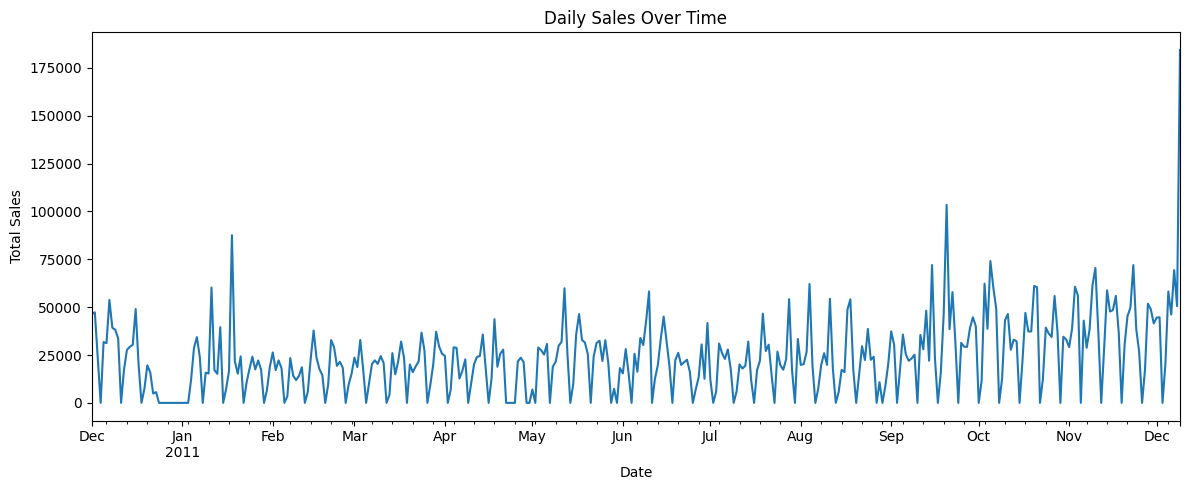

In [4]:
plt.figure(figsize=(12, 5))
daily_sales.plot()
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

ADF Statistic: -0.9218
p-value: 0.7807


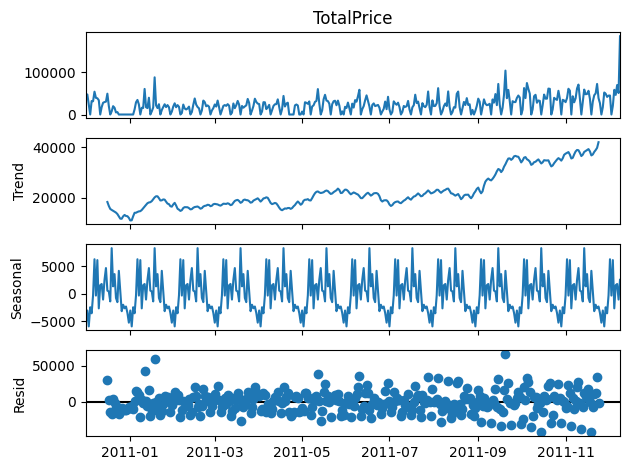

In [5]:
result = adfuller(daily_sales)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

decomp = seasonal_decompose(daily_sales, model='additive', period=30)
decomp.plot()
plt.tight_layout()
plt.show()

## ACF & PACF Analysis

ADF p-value (Before): 0.7807
ADF p-value (After): 0.0000


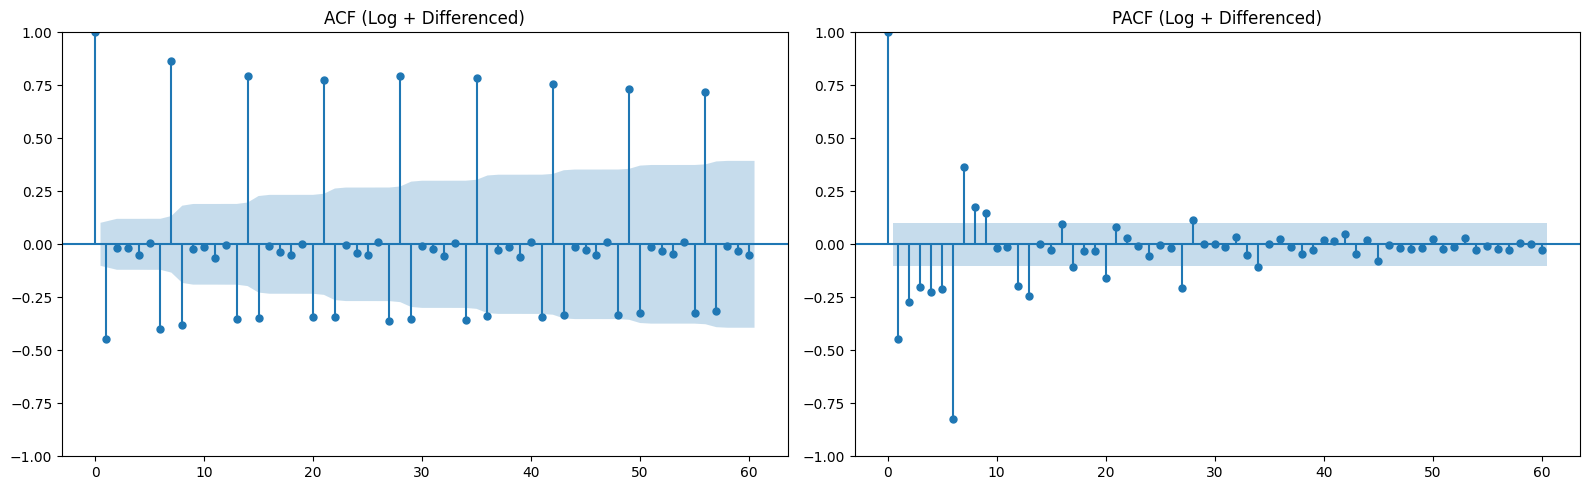

In [6]:
log_sales = np.log1p(daily_sales)
log_diff = log_sales.diff().dropna()

adf_before = adfuller(daily_sales)[1]
adf_after = adfuller(log_diff)[1]
print(f"ADF p-value (Before): {adf_before:.4f}")
print(f"ADF p-value (After): {adf_after:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(log_diff, lags=60, ax=ax[0], alpha=0.05)
ax[0].set_title("ACF (Log + Differenced)")
plot_pacf(log_diff, lags=60, ax=ax[1], method='ywm', alpha=0.05)
ax[1].set_title("PACF (Log + Differenced)")
plt.tight_layout()
plt.show()

## Outlier Detection & Cleaning

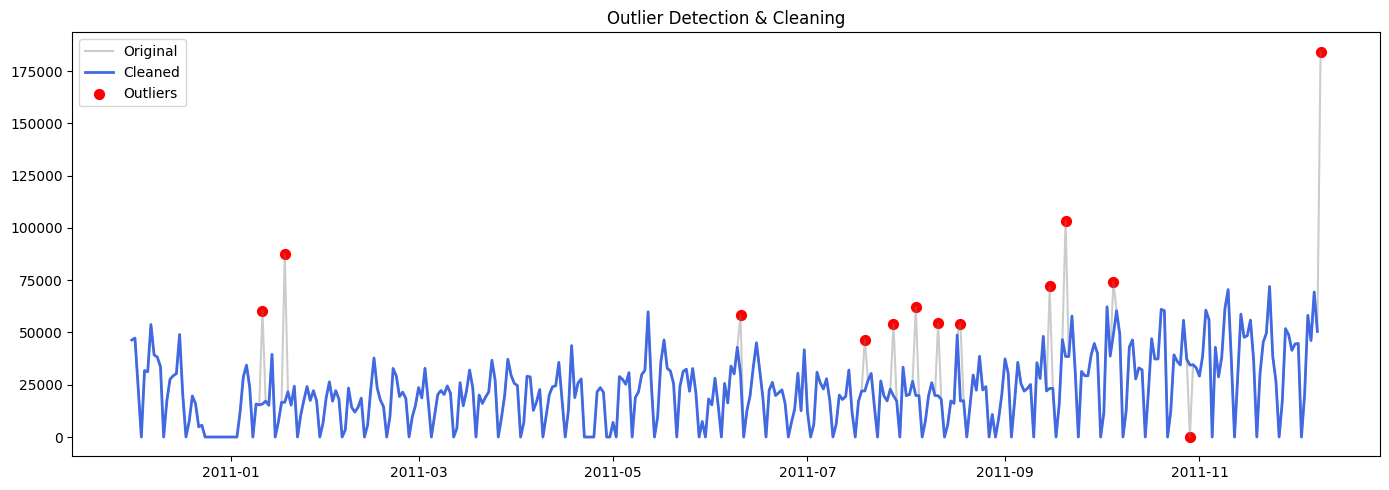

In [7]:
window = 30
q1 = daily_sales.rolling(window, center=True).quantile(0.25)
q3 = daily_sales.rolling(window, center=True).quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
iqr_mask = (daily_sales < lower_bound) | (daily_sales > upper_bound)

z_scores = (daily_sales - daily_sales.mean()) / daily_sales.std()
z_mask = np.abs(z_scores) > 3
outliers = iqr_mask | z_mask

cleaned = daily_sales.copy()
rolling_median = daily_sales.rolling(window=7, center=True).median()
cleaned[outliers] = rolling_median[outliers]

plt.figure(figsize=(14, 5))
plt.plot(daily_sales, label='Original', alpha=0.4, color='gray')
plt.plot(cleaned, label='Cleaned', linewidth=2, color='royalblue')
plt.scatter(daily_sales[outliers].index, daily_sales[outliers].values, color='red', s=50, label='Outliers')
plt.title("Outlier Detection & Cleaning")
plt.legend()
plt.tight_layout()
plt.show()

## Train-Test Split

In [8]:
train_size = int(len(daily_sales) * 0.9)
train, test = daily_sales[:train_size], daily_sales[train_size:]

## Exponential Smoothing Model

In [9]:
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=30)
fit = model.fit()
forecast = fit.forecast(len(test))

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

MAE: 21678.30, RMSE: 32367.28, R²: -0.1241


## ARIMA Model Optimization

In [10]:
optimal_arima_model = auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5,
                                 d=None, seasonal=False, stepwise=True,
                                 suppress_warnings=True, error_action='ignore', trace=True)

best_arima_order = optimal_arima_model.order
print(f"Best ARIMA order: {best_arima_order}")

arima_model = ARIMA(train, order=best_arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7558.916, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7540.181, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7446.508, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7556.920, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7416.120, Time=0.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7414.471, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7422.051, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7429.017, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7403.608, Time=0.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7425.531, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7405.031, Time=0.77 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=7403.017, Time=1.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=7

## Model Comparison

In [11]:
def safe_mape(y_true, y_pred):
    non_zero_mask = y_true != 0
    if non_zero_mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def evaluate_model(y_true, y_pred, model_name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    return {'Model': model_name, 'MAE': round(mae, 2), 'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2), 'R²': round(r2, 4), 'Bias': round(bias, 2)}

results = []
results.append(evaluate_model(test, forecast, 'Exponential Smoothing'))
results.append(evaluate_model(test, arima_forecast, 'Optimized ARIMA'))

metrics_df = pd.DataFrame(results)
print(metrics_df)

                   Model       MAE      RMSE  MAPE (%)      R²      Bias
0  Exponential Smoothing  21678.30  32367.28     34.65 -0.1241  -9424.78
1        Optimized ARIMA  20171.35  31333.60     35.46 -0.0535 -12595.41


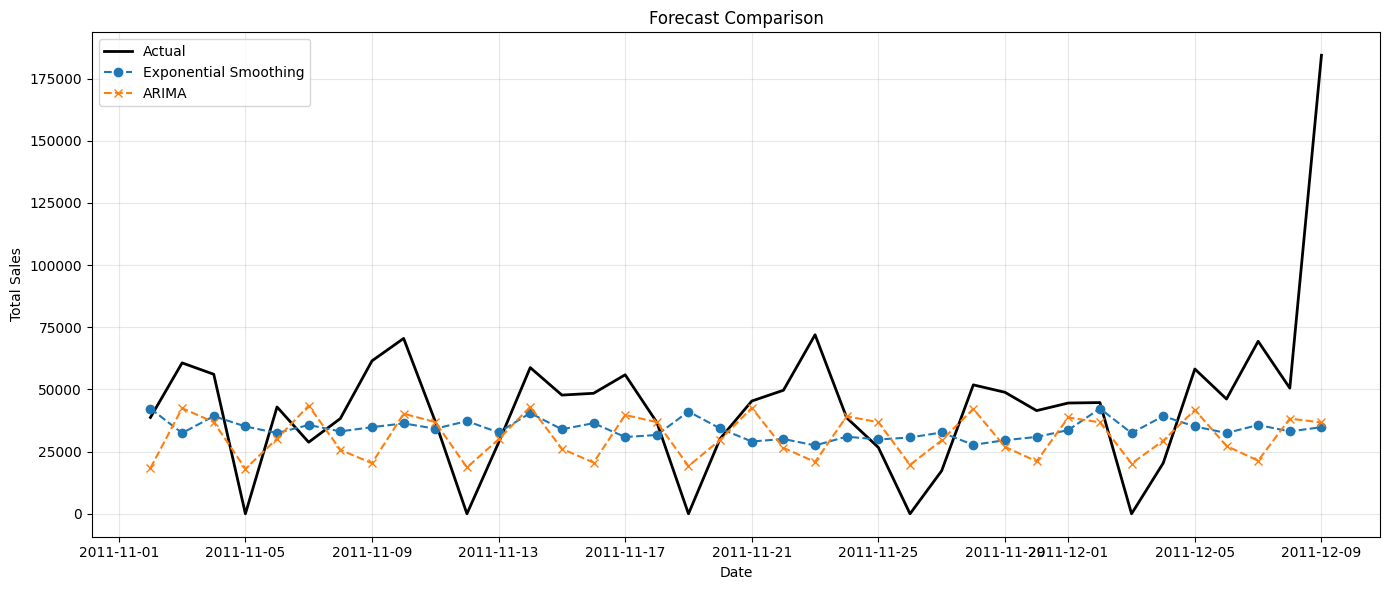

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label='Actual', color='black', linewidth=2)
plt.plot(test.index, forecast, label='Exponential Smoothing', linestyle='--', marker='o')
plt.plot(test.index, arima_forecast, label='ARIMA', linestyle='--', marker='x')
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Residual Analysis

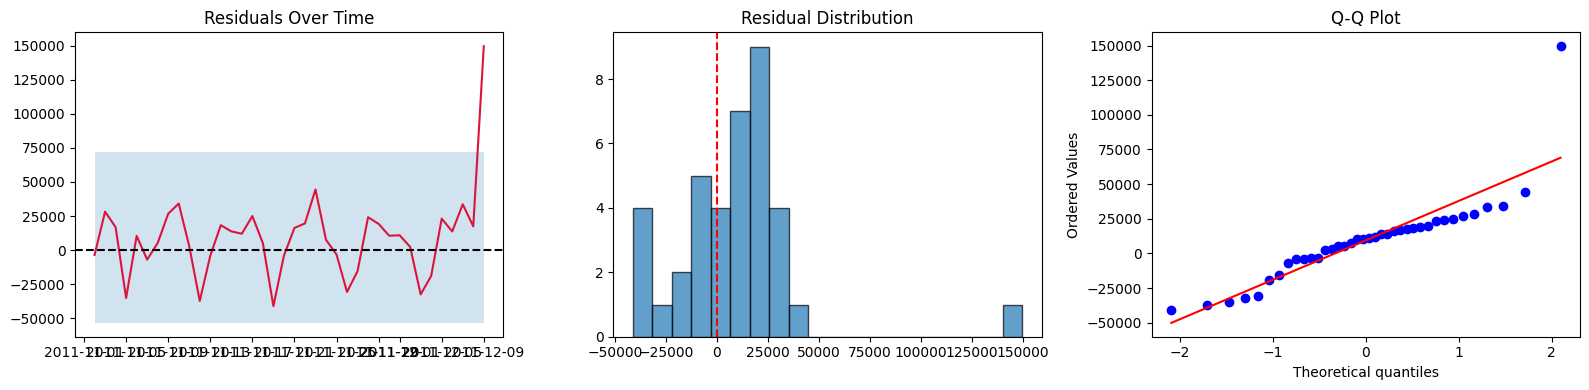

Mean: 9424.78, Std: 31380.38
Skewness: 2.07, Kurtosis: 8.73


In [13]:
residuals = test - forecast
res_mean = residuals.mean()
res_std = residuals.std()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(residuals, color='crimson', linewidth=1.5)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].fill_between(residuals.index, res_mean - 2*res_std, res_mean + 2*res_std, alpha=0.2)
axes[0].set_title('Residuals Over Time')

axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('Residual Distribution')

probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"Mean: {res_mean:.2f}, Std: {res_std:.2f}")
print(f"Skewness: {skew(residuals):.2f}, Kurtosis: {kurtosis(residuals):.2f}")

## Google Trends Integration

In [14]:
pytrends = TrendReq(hl='en-US', tz=360)
keywords = ['online shopping', 'e-commerce']
start_date = daily_sales.index.min().strftime('%Y-%m-%d')
end_date = daily_sales.index.max().strftime('%Y-%m-%d')
timeframe = f'{start_date} {end_date}'

pytrends.build_payload(kw_list=keywords, cat=0, timeframe=timeframe, geo='GB', gprop='')
gtrends_df = pytrends.interest_over_time()

if 'isPartial' in gtrends_df.columns:
    gtrends_df = gtrends_df.drop(columns=['isPartial'])

gtrends_df.columns = [col.replace(' ', '_').lower() + '_trend' for col in gtrends_df.columns]
gtrends_df_resampled = gtrends_df.resample('D').ffill()

daily_sales.index.name = 'Date'
gtrends_df_resampled.index.name = 'Date'

merged_df = pd.merge(daily_sales.to_frame(name='TotalPrice'), gtrends_df_resampled,
                     left_index=True, right_index=True, how='left')
merged_df.fillna(method='ffill', inplace=True)
merged_df.fillna(method='bfill', inplace=True)
merged_df.fillna(0, inplace=True)

print(f"Merged DataFrame shape: {merged_df.shape}")

Merged DataFrame shape: (374, 3)


## Consumer Trend Segmentation

In [15]:
segmented_df = merged_df.copy()
segmented_df['day_of_week'] = segmented_df.index.dayofweek
segmented_df['month'] = segmented_df.index.month
segmented_df['quarter'] = segmented_df.index.quarter
segmented_df['is_weekend'] = segmented_df.index.dayofweek.isin([5, 6]).astype(int)
segmented_df['week_of_year'] = segmented_df.index.isocalendar().week.astype(int)
segmented_df['rolling_mean_7d'] = segmented_df['TotalPrice'].rolling(window=7).mean()
segmented_df['rolling_std_7d'] = segmented_df['TotalPrice'].rolling(window=7).std()
segmented_df['lag_1d'] = segmented_df['TotalPrice'].shift(1)
segmented_df['lag_7d'] = segmented_df['TotalPrice'].shift(7)
segmented_df['lag_30d'] = segmented_df['TotalPrice'].shift(30)

for col in ['rolling_mean_7d', 'rolling_std_7d', 'lag_1d', 'lag_7d', 'lag_30d']:
    segmented_df[col].fillna(segmented_df[col].mean(), inplace=True)

feature_cols = ['online_shopping_trend', 'e-commerce_trend', 'day_of_week', 'month',
                'quarter', 'is_weekend', 'week_of_year', 'rolling_mean_7d',
                'rolling_std_7d', 'lag_1d', 'lag_7d', 'lag_30d']
features_for_clustering = segmented_df[feature_cols]

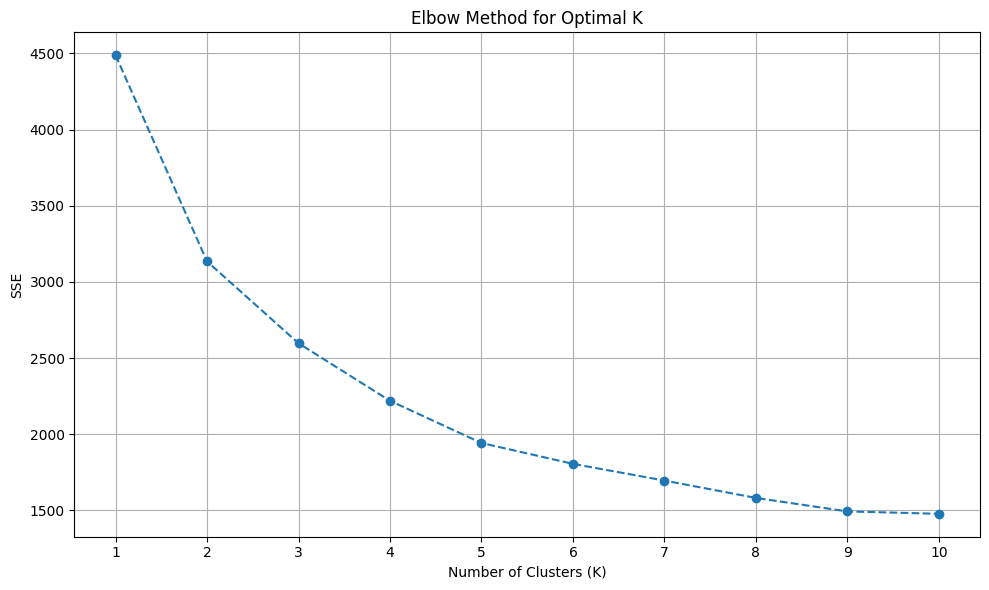

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

k_values = range(1, 11)
sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

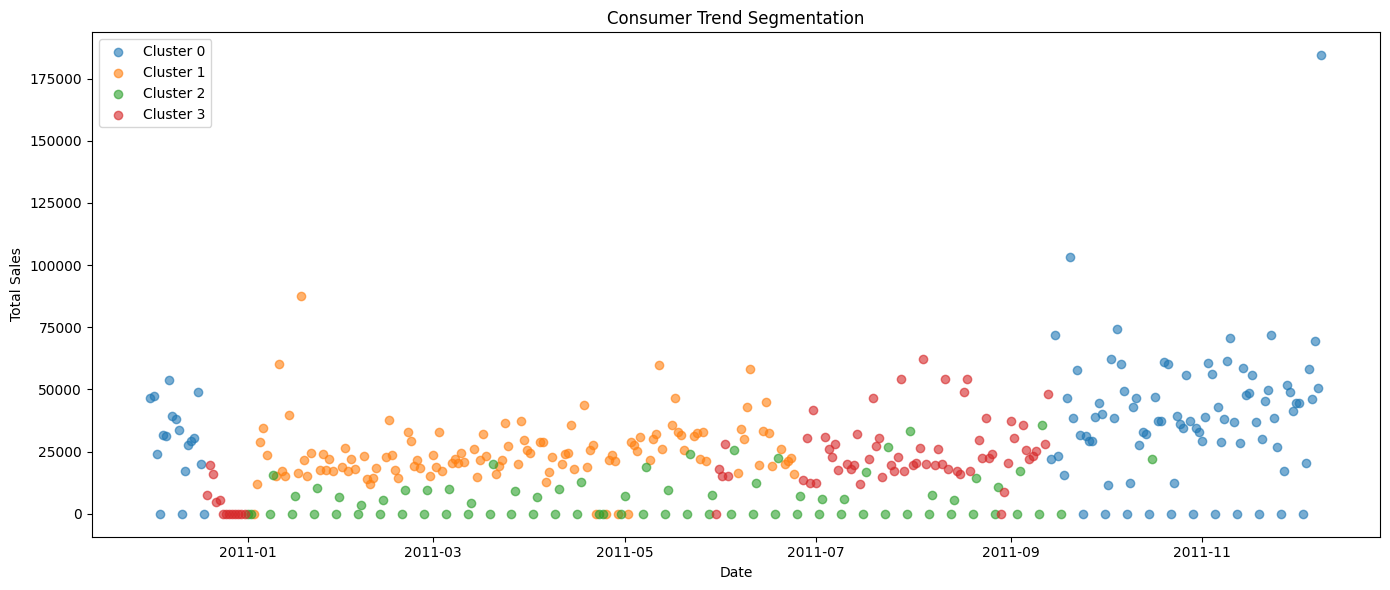

         count          mean           std  min        25%       50%  \
Cluster                                                                
0        103.0  37296.270214  25210.132317  0.0  27158.670  37333.52   
1        120.0  24749.561092  11894.911382  0.0  18311.845  22862.35   
2         76.0   6296.367895   8745.180934  0.0      0.000      0.00   
3         75.0  21618.943747  14257.245138  0.0  14838.015  19861.56   

                75%        max  
Cluster                         
0        48645.7200  184349.28  
1        29658.2400   87589.11  
2         9738.5325   35511.67  
3        27941.5300   62079.61  


In [17]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
segmented_df['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(14, 6))
for cluster in range(optimal_k):
    cluster_data = segmented_df[segmented_df['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['TotalPrice'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('Consumer Trend Segmentation')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

print(segmented_df.groupby('Cluster')['TotalPrice'].describe())